In [21]:
# import save_load as sl
# import preprocess_data as ppd
import torch
from torch import nn
from torch.utils.data import DataLoader
# from model import DnCNN
# from Dataset import Img_Dataset
import numpy as np 
import pathlib

# Importing utitility functions for training
from PT_files.model import DnCNN, DnCNN_B
from PT_files.Dataset import Img_Dataset, Large_Img_Dataset
import PT_files.preprocess_data as ppd
import PT_files.save_load as sl
import matplotlib.pyplot as plt

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [22]:
data_6k = sl.NERSC_load('test_data70-6000.npy')

Function that uses 2k by 2k slices

In [23]:
def full_grid_pass_window(dataset,
                   model,
                   samp_idx,
                   h_start,
                   h_end,
                   w_start,
                   w_end):
    
    """
    Conducts denoising in 2000x2000 sub-image slices of the whole 
    6000x6000 focal plane image. It implements the first of three
    passes of the image. It implements 9 inferences over the whole
    focal plane image and covers the entire image.
    

    Parameters:
    -----------
    
    dataset: np.array
        Should be a 5-D array of:
        
        dataset.shape = (dataset, number of samples, channel number,
                         number of pixels in height, number of pixels in width)
    
    model: pytorch model
        Should be DnCNN or DnCNN-B as proposed as in Zheng et al. 2017
        
    samp_idx: int
        Specific sample from test set that you want inference ran on.
    
    w_start: int
        Starting index of the width of the subimage window
        
    w_end: int
        Ending index of the width of the subimage window
        
    h_start: int
        Starting index of the height of the subimage window
        
    h_end: int
        Ending index of the height of the subimage window  
        
    Returns:
    --------
    
    full: np.array
        A (6000, 6000) array that contains all 9 of the (2000x2000) 
        sub-images combined together
        
        
    count: np.array
        An array that counts how many times an individual pixel has had
        a denoising window applied to it. This will be used to average
        over the pixels that are denoised multiple times.
    """
    
    full = np.empty((1, 1, 6000,6000))
    count = np.empty((1, 1, 6000,6000))
    
    noise_data = dataset[0]
    param_name = "2k_model_bs64_e200.pth"
    
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / param_name
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval();
    # telling pytorch this is for inference and not learning, so keeps the weights unchanged
    with torch.no_grad():
        
        torch.cuda.empty_cache()
        test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1,:, w_start:w_end, h_start:h_end])
        test_noise = test_noise.to(device)

        output = model(test_noise)
        resid_img = output.to('cpu').detach().numpy()
        
        full[:, :, h_start:h_end, w_start:w_end] += resid_img
        count[:, :, h_start:h_end, w_start:w_end] += 1
        
    return full, count

In [29]:
slice_list = [2000, 4000, 6000]
full1 = np.empty((1, 1, 6000, 6000))
count1 = np.empty((1, 1, 6000, 6000))
for i in range(len(slice_list)):
    full1[:,:, 0:2000, 0:slice_list[i]]+= full_grid_pass_window(dataset=data_6k,
                                     model= DnCNN,
                                     samp_idx=0,
                                     w_start=0,
                                     w_end=slice_list[i],
                                     h_start=0,
                                     h_end=2000)


ValueError: operands could not be broadcast together with shapes (1,1,2000,2000) (2,1,1,6000,6000) (1,1,2000,2000) 

In [20]:
slice_list = [2000, 4000, 6000]
    
for i in range(len(slice_list)):
    full1, count1 = full_grid_pass_window(dataset=data_6k,
                                     model= DnCNN,
                                     samp_idx=0,
                                     w_start=0,
                                     w_end=slice_list[i],
                                     h_start=0,
                                     h_end=2000)

for j in range(len(slice_list)):
    full2, count2 = full_grid_pass_window(dataset=data_6k,
                                     model= DnCNN,
                                     samp_idx=0,
                                     w_start=0,
                                     w_end=slice_list[j],
                                     h_start=0,
                                     h_end=4000)

for k in range(len(slice_list)):
    full3, count3 = full_grid_pass_window(dataset=data_6k,
                                     model=DnCNN,
                                     samp_idx=0,
                                     w_start=0,
                                     w_end=slice_list[k],
                                     h_start=0,
                                     h_end=6000)

full = full1 + full2 + full3

ValueError: operands could not be broadcast together with shapes (1,1,2000,4000) (1,1,4000,2000) (1,1,2000,4000) 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24,20))
vmin, vmax = np.percentile(data_6k[0][0][0], (1,99))

ax[0].imshow(data_6k[0][0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[0].axis('off')
ax[0].set_title('Noisy Sample')
ax[1].imshow(full[0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[1].axis('off')
ax[1].set_title('Denoised Sample')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24,20))
vmin, vmax = np.percentile(data_6k[0][0][0][2200:2400,1000:1200], (1,99))


ax[0].imshow(data_6k[0][0][0][2200:2400,1000:1200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[0].axis('off')
ax[0].set_title('Noisy Sample', fontsize=30)
ax[1].imshow(full[0][0][2200:2400,1000:1200],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[1].axis('off')
ax[1].set_title('Denoised Sample', fontsize=30)
ax[2].imshow(data_6k[1][0][0][2200:2400,1000:1200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[2].axis('off')
ax[2].set_title('Truth Sample', fontsize=30)

In [5]:
full, count = full_grid_pass_window(dataset=data_6k,
                             model= DnCNN,
                             samp_idx=0,
                             w_start=0,
                             w_end=2000,
                             h_start=0,
                             h_end=2000)

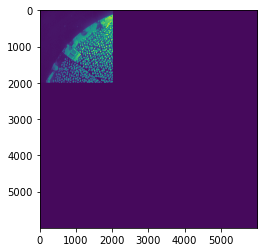

In [6]:
plt.imshow(data_6k[0][0][0][:,:])
plt.imshow(data_6k[0][0][0][0:2000,0:2000])
plt.imshow(full[0][0][:, :])

In [6]:
# def full_grid_pass(dataset,
#                    model,
#                    samp_idx):
    
#     slice_list = [2000, 4000, 6000]
    
#     for i in range(slice_list):
#         for j in range(slice_list):
#             full, count = full_grid_pass_window(dataset=data_6k,
#                                      model= DnCNN,
#                                      samp_idx=0,
#                                      w_start=0,
#                                      w_end=slice_list[j],
#                                      h_start=0,
#                                      h_end=slice_list[i])

In [15]:
# def full_grid_pass(dataset,
#                    model,
#                    samp_idx):
    
#     slice_list = [2000, 4000, 6000]
#     final_full = np.empty((1, 1, 6000,6000))
#     final_count = np.empty((1, 1, 6000,6000))
    
#     for i in range(len(slice_list)):
#         for j in range(len(slice_list)):
#             full, count = full_grid_pass_window(dataset=data_6k,
#                                      model= DnCNN,
#                                      samp_idx=0,
#                                      h_start=0,
#                                      h_end=slice_list[i],
#                                      w_start=0,
#                                      w_end=slice_list[j])
            
#             final_full[:, :, 0:slice_list[i], 0:slice_list[j]] += full
#             final_count[:, :, 0:slice_list[i], 0:slice_list[j]] += 1
            
#     return final_full, final_count



def full_grid_pass(dataset,
                   model,
                   samp_idx):
    
    slice_list = [0, 2000, 4000, 6000]
    final_full = np.empty((1, 1, 6000,6000))
    final_count = np.empty((1, 1, 6000,6000))
    
    for i in range(3):
        for j in range(3):
            full, count = full_grid_pass_window(dataset=data_6k,
                                     model= DnCNN,
                                     samp_idx=0,
                                     h_start=slice_list[i],
                                     h_end=slice_list[i+1],
                                     w_start=slice_list[j],
                                     w_end=slice_list[j+1])
            
            final_full[:, :, slice_list[i]:slice_list[i+1], slice_list[j]:slice_list[j+1]] += full
            final_count[:, :, slice_list[i]:slice_list[i+1], slice_list[j]:slice_list[j+1]] += 1
            
    return full, count

In [16]:
full, count = full_grid_pass(dataset=data_6k, model=DnCNN, samp_idx=0)

ValueError: operands could not be broadcast together with shapes (1,1,2000,2000) (1,1,6000,6000) (1,1,2000,2000) 

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24,20))
vmin, vmax = np.percentile(data_6k[0][0][0][2200:2400,1000:1200], (1,99))


ax[0].imshow(data_6k[0][0][0][2200:2400,1000:1200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[0].axis('off')
ax[0].set_title('Noisy Sample', fontsize=30)
ax[1].imshow(full[0][0][2200:2400,1000:1200],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[1].axis('off')
ax[1].set_title('Denoised Sample', fontsize=30)
ax[2].imshow(data_6k[1][0][0][2200:2400,1000:1200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[2].axis('off')
ax[2].set_title('Truth Sample', fontsize=30)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24,20))
ax.imshow(full[0][0])

In [11]:
def horizontal_grid_pass(dataset, model, samp_idx):
    
    horiz_slice_list = [3000, 5000]
    vert_slice_list = [2000, 4000, 6000]
    
    for i in range(len(horiz_slice_list)):
        for j in range(len(vert_slice_list)):

            full, count = full_grid_pass_window(dataset=data_6k,
                                     model= DnCNN,
                                     samp_idx=0,
                                     h_start=1000,
                                     h_end=horiz_slice_list[i]
                                     w_start=0,
                                     w_end=vert_slice_list[j]
                                     )
            
    return full, count

SyntaxError: invalid syntax (2449392972.py, line 14)

In [ ]:
full, count = horizontal_grid_pass(dataset=data_6k, model=DnCNN, samp_idx=0)

CUDA out of memory. I can see why because I'm trying to run inference on 9 separate images

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24,20))
ax.imshow(full[0][0])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24,20))
vmin, vmax = np.percentile(data_6k[0][0][0][1000:1200,1000:1200], (1,99))
ax[0].imshow(data_6k[0][0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[0].axis('off')
ax[0].set_title('Noisy Sample')
ax[1].imshow(full[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax[1].axis('off')
ax[1].set_title('Denoised Sample')